# Answering the CEO's Three Questions

### In this section we will answer the three main questions:

1. Which houses should the House Rocket buy and by which  price?
2. Once the houses are bought, for what price should they be sold?
3. What is the best time of the year to sell the houses?
4. The House Rocket should do renovate the houses to increase the selling price? What parts of the houses should the House Rocket renovate? What is the price increase given for each renovation option?

In [7]:
import os
import pandas as pd
import seaborn as sns
from notebooks.get_local_folder import get_local_folder

## Question 1: Which houses should the House Rocket buy and by which  price?

### We are going to add two new columns to the dataset:
1. "Median Price ID": contains the median price of houses per ZipCode.
2. "Status": contains the information whether or not to buy the house based on the following conditions:
    * Based on the insights from the notebook "0.1-Data_Exploration.ipynb", places with grade of variable "Gride" equal or greater than 8.
    * Houses with condition equal to or greater than 3.
    * Houses priced below the median price for their region (the "Median Price ID" column).

##### Note: We are going to use the dataset with outliers, because if a region has houses well above the average, they will influence the median price of houses in the region. 

In [65]:
# Load data
abs_path_to_folder = get_local_folder()
dataset_path = os.path.join(abs_path_to_folder, "../data/cleaned/houses_data.parquet")
houses = pd.read_parquet(dataset_path)

In [66]:
media_price_by_zipcode = houses[['Price','ZipCode']].groupby('ZipCode').median().reset_index()
media_price_by_zipcode.rename(columns = {'Price':'Median Price ZipCode'}, inplace = True)
houses = pd.merge(houses, media_price_by_zipcode, on='ZipCode', how='inner')


houses['Status'] = 'Dont Buy'
houses.loc[ ( houses['Price'] <= houses['Median Price ZipCode'] ) & 
( houses['Condition'] >= 3 ) & 
( houses['Grade'] >= 8 ), 'Status' ] = 'Buy'

In [67]:
houses[["ID", "Price", "ZipCode", "Median Price ZipCode", "Status"]].head()

,ID,Price,ZipCode,Median Price ZipCode,Status
0,7129300520,221900.0,98178,278277.0,Dont Buy
1,4060000240,205425.0,98178,278277.0,Dont Buy
2,4058801670,445000.0,98178,278277.0,Dont Buy
3,2976800796,236000.0,98178,278277.0,Dont Buy
4,6874200960,170000.0,98178,278277.0,Dont Buy


### The chart bellow compares the median price of homes categorized as "Buy" and "Dont Buy".

<Axes: xlabel='Status', ylabel='Price'>

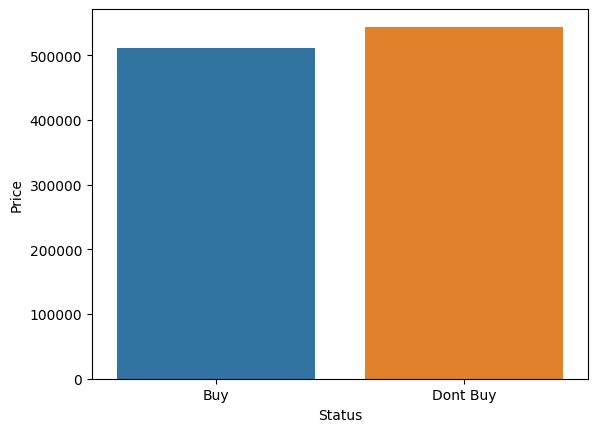

In [68]:
median_price_status = houses[['Price','Status']].groupby('Status').mean().reset_index()
sns.barplot(data=median_price_status, y='Price', x='Status')

## Question 2: Once the houses are bought, for what price should they be sold?

Now that we have a new dataset of homes to buy, let's assume that House Rocket has purchased all homes with "Buy" Status, let's calculate their ideal resale price for each house.

First, let's create a new column called "Season", which will contain the season that the house became available for purchase. Then let's create a dataset with the median price per season.

**Note**: we will use the dataset without outliers, because if in a certain season outlier houses become available, it will influence the price of an entire season.

In [62]:
houses_wo = pd.read_parquet(os.path.join(abs_path_to_folder, "../data/without_outliers/houses_without_outliers.parquet"))

In [63]:
def create_season_column(df: pd.DataFrame):
    """Create a new colunm named "Season", which contains the season based in the "Date" colunm"""
    import pandas as pd
    import numpy as np

    df['Month'] = pd.to_datetime(df['Date']).dt.strftime('%m')
    df['Month'] = df['Month'].astype(np.int64)


    df['Season'] = 'Winter'
    df.loc[(df['Month'] >= 3) & (df['Month'] < 6), 'Season'] = 'Spring'
    df.loc[(df['Month'] >= 6) & (df['Month'] < 9), 'Season'] = 'Summer'
    df.loc[(df['Month'] >= 9) & (df['Month'] < 12), 'Season'] = 'Fall'

    return df.drop(columns="Month")

houses_wo = create_season_column(houses_wo[['Price','Date']].copy())
mean_price_by_season = houses_wo[['Price','Season']].groupby('Season').mean().reset_index()
mean_price_by_season.columns = ['Season','Median Price Season']

/tmp/ipykernel_1097/665452922.py:6: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['Month'] = pd.to_datetime(df['Date']).dt.strftime('%m')


Mean price by season:

In [64]:
mean_price_by_season.round(1)

,Season,Median Price Season
0,Fall,503448.8
1,Spring,514740.8
2,Summer,511177.0
3,Winter,504649.9


Now with the dataset with only the houses purchased by House Rocket, let's create a new column "Average Total Price", which contains the average of the following values: 
* Median price of the region (ZipCode).
* Average price of the season that the house became available for purchase.

In [69]:
houses = houses.loc[houses['Status'] == 'Buy']
houses = create_season_column(houses.copy())
houses = pd.merge(houses, mean_price_by_season, on='Season', how='inner')

houses['Total Avarage Price'] = ((houses['Median Price ZipCode'] + houses['Median Price Season']) / 2)
houses = houses.round(1).copy() # Remove notation

/tmp/ipykernel_1097/665452922.py:6: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['Month'] = pd.to_datetime(df['Date']).dt.strftime('%m')


### The dataset with the new columns looks like:

In [72]:
houses[["ID", "Price", "ZipCode", "Median Price ZipCode", "Season", "Median Price Season", "Total Avarage Price"]].head(2)

,ID,Price,ZipCode,Median Price ZipCode,Season,Median Price Season,Total Avarage Price
0,3810000860,240000.0,98178,278277.0,Summer,511177.0,394727.0
1,3348401490,265000.0,98178,278277.0,Summer,511177.0,394727.0


Now let's create two new columns: "Sale Price" and "Profit".
1. "Sale Price": the recommended selling price of the house, the price recommendation will be based on the following conditions:
    - If the purchase price of the house is higher than the "Total Avarage Price", then the suggested selling price will be the purchase price + 10%.
    - If the purchase price of the house is less than the "Total Avarage Price", then the suggested selling price will be the purchase price + 30%.
2. "Profit": the profit from the resale of the house. It will be the difference between the sale price less the purchase value.

In [73]:
houses['Sale Price'] = 0.0 
houses['Profit'] = 0.0

houses.loc[ houses['Price'] > houses['Total Avarage Price'], 'Sale Price' ] = houses['Price'] * 1.1
houses.loc[ houses['Price'] <= houses['Total Avarage Price'], 'Sale Price' ] = houses['Price'] * 1.3

houses['Profit'] = houses['Sale Price'] - houses['Price']
houses['Total Avarage Price'] = houses['Total Avarage Price'].round(1)

### The final dataset looks like this:

In [75]:
houses[["ID", "Price", "ZipCode", "Median Price ZipCode", "Season", "Median Price Season", "Total Avarage Price", "Sale Price", "Profit"]].head() # First five rows

,ID,Price,ZipCode,Median Price ZipCode,Season,Median Price Season,Total Avarage Price,Sale Price,Profit
0,3810000860,240000.0,98178,278277.0,Summer,511177.0,394727.0,312000.0,72000.0
1,3348401490,265000.0,98178,278277.0,Summer,511177.0,394727.0,344500.0,79500.0
2,3992700036,415000.0,98125,425000.0,Summer,511177.0,468088.5,539500.0,124500.0
3,2926049449,384400.0,98125,425000.0,Summer,511177.0,468088.5,499720.0,115320.0
4,1787600165,396500.0,98125,425000.0,Summer,511177.0,468088.5,515450.0,118950.0


## Question 3: What is the best time of the year to sell the houses?

The answer to that question will be the best season to sell each house. But before answering it, let's look at the difference in the average price per season.

In [76]:
mean_price_by_season.round(1)

,Season,Median Price Season
0,Fall,503448.8
1,Spring,514740.8
2,Summer,511177.0
3,Winter,504649.9


After analyzing the above metrics, we can see that the difference between prices per season can reach $31,500, meaning the best season for sale is **spring**.

## Question 4: The House Rocket should do renovate the houses to increase the selling price? What parts of the houses should the House Rocket renovate?

First, let's see if it's really worth renovating the houses, so let's compare the average price of the houses that were not renovated and those that were.

**Note**: for this we will use the dataset without outliers, so that the outliers do not affect the analysis result.

In [77]:
houses_wo = pd.read_parquet(os.path.join(abs_path_to_folder, "../data/without_outliers/houses_without_outliers.parquet"))

In [78]:
# Create a new column with information if the house has already been renovated or not.
houses_wo['Renovated'] = 'No' 
houses_wo.loc[ houses_wo['Year Renovated'] != 0, 'Renovated'] = 'Yes'

In [81]:
renovated_comparation = houses_wo[['Price','Renovated']].groupby('Renovated').mean().reset_index().round(1) 
print('Avarage price of renovated houses $ {:.2f}'.format(renovated_comparation.iloc[1,1]))
print('Average price of unrenovated houses $ {:.2f}'.format(renovated_comparation.iloc[0,1]))
print('The difference is $ {}, acress of {:.2f}%'.format(
    renovated_comparation.iloc[1,1] - renovated_comparation.iloc[0,1],
    (((renovated_comparation.iloc[1,1] - renovated_comparation.iloc[0,1]) * 100) / renovated_comparation.iloc[1,1])
))

Avarage price of renovated houses $ 651781.50
Average price of unrenovated houses $ 503012.30
The difference is $ 148769.2, acress of 22.83%


After seeing the margin of price difference between renovated and unrenovated homes, it is clear that renovated homes have a higher average and median price, in both cases an increase of approximately 20% on the price.

Now let's see which attributes are most important to renovate the house.

In [84]:
corr = houses_wo.loc[houses_wo['Renovated'] != 0].corr()
corr['Price'].sort_values(ascending=False).iloc[1:].reset_index()

/tmp/ipykernel_1097/103306110.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = houses_wo.loc[houses_wo['Renovated'] != 0].corr()


,index,Price
0,Grade,0.673951
1,Sqft Living,0.669080
2,Sqft Living 15,0.598269
3,Sqft Above,0.570982
4,Bathrooms,0.497622
5,Latitude,0.381467
6,View,0.324330
7,Bedrooms,0.313093
8,Sqft Basement,0.282128
9,Floors,0.277596


The attributes that have a high positive correlation with the price of renovated homes is the Living Square Foot and the number of bathrooms. In my option, the best decision to renovate the houses would be to build a new bathroom as a new addition to the house, increasing the number of bathrooms in the house and the Square Foot of the house itself.

According [Home Guide](homeguide.com), the construction of a bathroom as a new addition costs on average $22,000. A high price, but as seen, the average price of a renovated house can be up to 22% higher than an unrenovated house.

---

Now let's add two new columns to our dataset:
1. "Renovation Sale Price": contains the recommended selling price of the home after renovation.
1. "Profit Renovation": contains the profit of renovated houses.

In [89]:
houses['Renovation Sale Price'] = (houses['Sale Price'] * 1.20).round(1) # The recommended sale price of renovated houses will be 120% of the sale price of unrenovated houses.
houses['Profit Renovation'] = (houses['Renovation Sale Price'] - houses['Price']).round(1)
houses = houses.round(1) # Revmoce scientific notation

houses.to_parquet(os.path.join(abs_path_to_folder, "../reports/data/final_houses_sale.parquet"), index=False) # Save dataset

Now, the final dataset will look like:

In [90]:
houses[["ID", "Price", "Status", "Median Price ZipCode", "Season", "Median Price Season", "Total Avarage Price", "Sale Price", "Profit", "Renovation Sale Price", "Profit Renovation"]].head()

,ID,Price,Status,Median Price ZipCode,Season,Median Price Season,Total Avarage Price,Sale Price,Profit,Renovation Sale Price,Profit Renovation
0,3810000860,240000.0,Buy,278277.0,Summer,511177.0,394727.0,312000.0,72000.0,374400.0,134400.0
1,3348401490,265000.0,Buy,278277.0,Summer,511177.0,394727.0,344500.0,79500.0,413400.0,148400.0
2,3992700036,415000.0,Buy,425000.0,Summer,511177.0,468088.5,539500.0,124500.0,647400.0,232400.0
3,2926049449,384400.0,Buy,425000.0,Summer,511177.0,468088.5,499720.0,115320.0,599664.0,215264.0
4,1787600165,396500.0,Buy,425000.0,Summer,511177.0,468088.5,515450.0,118950.0,618540.0,222040.0
